# **Introduction & Objective**

This project explores the capabilities of multimodal models in **Visual Question Answering (VQA)**, where systems generate meaningful text responses from both images and natural language questions.

We evaluate and compare three models using a **custom benchmark of image-question pairs at varying difficulty levels**. Our goal is to identify each model’s strengths, weaknesses, and limitations, and offer practical guidance on when to use which model, where they may fall short, and how they could be improved.

This notebook walks through the experiment step by step, while the accompanying presentation introduces multimodal models more broadly.

# VQA with BLIP2, ViLT, and GIT Model




# **Models**

We evaluate three vision-language models - ViLT, BLIP-2, and GIT - on their ability to answer natural language questions grounded in visual inputs. Each model represents a different architecture and strategy for fusing visual and textual information:

---

**BLIP-2** (Bootstrapped Language-Image Pretraining) separates vision and language encoders and uses a query-based transformer to bridge them, enabling efficient and effective cross-modal alignment.
  * **Why BLIP-2?:** It offers a **modular** yet powerful architecture leveraging **dual attention**. This allows us to test how well a model that fuses inputs later in the pipeline can perform on grounded visual reasoning tasks.

**BLIP-2 Architecture**

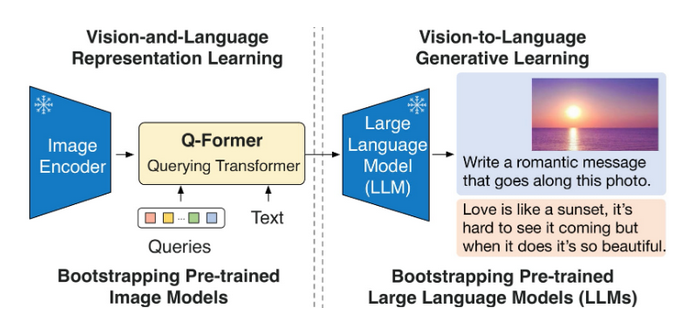

*source: https://huggingface.co/docs/transformers/en/model_doc/blip-2*
---

**ViLT** (Vision-and-Language Transformer) processes images and text using a single transformer architecture with minimal visual preprocessing, directly embedding image patches alongside text.
  * **Why ViLT?:** It represents a fully **unified architecture** that performs early fusion of vision and language, allowing us to evaluate how well a **lightweight, end-to-end model** can handle multimodal reasoning without relying on heavy visual backbones.

**ViLT Architecture**

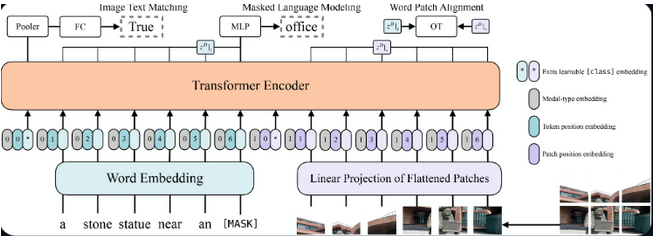

*source: https://huggingface.co/docs/transformers/model_doc/vilt*

---
         
**GIT** (Generative Image-to-Text Transformer) treats vision-language tasks as generative problems, encoding images into visual tokens and directly generating textual responses autoregressively.
  * **Why GIT?:** It emphasizes grounding — using **cross-modal attention** to link text to specific image regions — making it ideal for evaluating how well a generative approach can **localize and reason** over visual content when producing free-form answers.

**GIT Architecture**

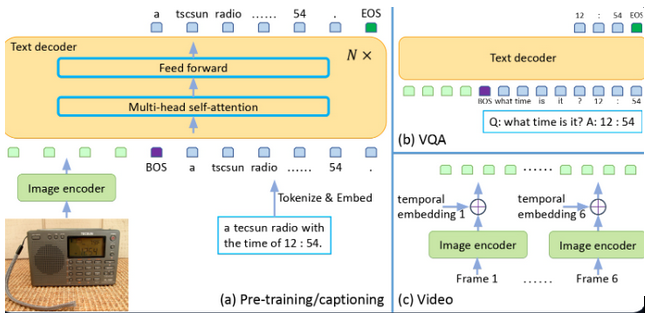

*source: https://huggingface.co/docs/transformers/en/model_doc/git*

# **Approach**

To test these models, we construct a set of images and questions at three levels of complexity:

**Image complexity:**

* Simple object scenes
* Multi-object or context-rich scenes
* Spatially or semantically complex scenes (i.e. crowd dynamics, relationships)

**Question complexity:**

* Descriptive (“What is this?”)
* Relational (“What is the object next to the dog?”)
* Reasoning-based (“Why is the person looking left?”)

Additionally, we evaluate each model across five core vision-language **capabilities**:

* Object Presence
* Object Counting
* Attribute Recognition
* Scene Understanding
* Commonsense Reasoning

For each image, we design one question targeting each of these five capabilities.

---

**Model performance** is evaluated by pairing each image with each corresponding question and generating answers using all three models. Each answer is scored by two independent annotators based on three criteria:

* Correctness (Is the answer factually accurate?)
* Relevance (Does it address what the question asked?)
* Completeness (Does it fully answer all parts of the question?)

Each criterion is scored on a **scale from 1 to 5**, with higher scores indicating stronger performance. Scores from both evaluators are averaged to ensure objectivity. This produces a total score for each image-question-model combination.

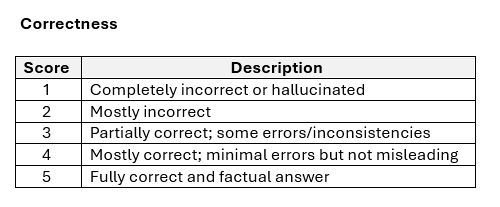

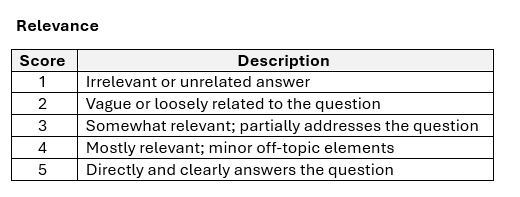

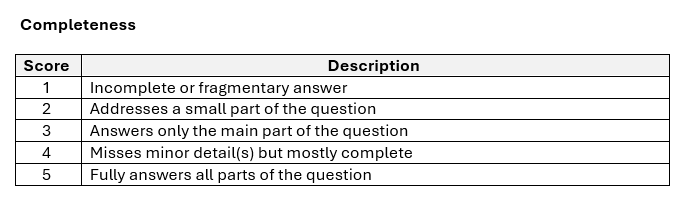

By analyzing these scores, we identify **strengths, weaknesses, and performance patterns** across the three models. This allows us to make **informed comparisons** and **derive practical recommendations** based on real-world visual reasoning tasks.

**Scoring Example**

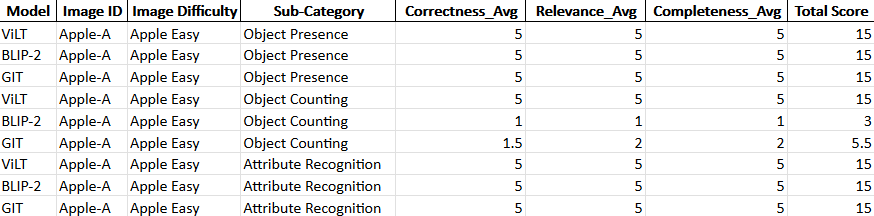

# Install dependencies

In [ ]:
# Install dependencies
!pip install transformers
!pip install pillow


Import Libraries

In [ ]:
import pandas as pd
from PIL import Image
import requests
import time
import torch
from transformers import (
    Blip2Processor, Blip2ForConditionalGeneration,
    ViltProcessor, ViltForQuestionAnswering,
    AutoProcessor, AutoModelForCausalLM
)
import re
from IPython.display import display, Image as IPyImage


# Load data (List of Questions and Images are listed in csv file)

In [ ]:
# Load CSV from a published Google Sheet URL
sheet_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSoqvujQtDw4kDHkpZmXEpdATCBIfH0GrRfDv47tfk15-8e2IsXzFvooES9X-qPWA/pub?output=csv"

# Read the CSV content into a pandas DataFrame
df_input = pd.read_csv(sheet_url)

# Confirm that the sheet has been loaded
print("Data loaded successfully")

# Display the DataFrame
pd.set_option('display.max_columns', None)       # Show all columns
pd.set_option('display.max_colwidth', None)      # Show full column content
pd.set_option('display.width', None)             # No fixed width cutoff
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping
df_input


Data loaded successfully


,Image name,Image URL,Question 1,Question 2,Question 3,Question 4,Question 5
0,Apple (Easy),https://raw.githubusercontent.com/natawan/GenAI/main/Apple%20-%20easy.png,what object is placed on the table?,how many apples are on the table?,what color is the apple?,where is the apple positioned within the scene?,why might someone place a single apple on a plain table?
1,Apple (Medium),https://raw.githubusercontent.com/natawan/GenAI/main/Apple%20-%20medium.png,what fruits can be seen on the kitchen counter?,how many fruits are present in the image?,"what objects are near the apple, and what condition are they in?",what actions are likely taking place in this kitchen scene?,why might someone be preparing these particular items together?
2,Apple (Hard),https://raw.githubusercontent.com/natawan/GenAI/main/Apple%20-%20hard.png,what items are visible on the kitchen table?,how many people are involved in cooking?,what cooking tools or ingredients can you identify?,what is the overall activity or task happening in the scene?,"what food might the people be preparing, based on the objects and actions?"
3,Dog (Easy),https://raw.githubusercontent.com/natawan/GenAI/main/Dog%20-%20easy.png,what animal is visible in the image?,how many animals are in the image?,what color is the dog's fur?,"what is the dog doing, and where is it positioned?",why might the dog be sitting still and looking at the camera?
4,Dog (Medium),https://raw.githubusercontent.com/natawan/GenAI/main/Dog%20-%20medium.png,what objects or people are visible in the backyard?,how many people are in the image?,what is the child wearing or holding?,what activity is happening between the child and the dog?,what is likely to happen next in this scene?
5,Dog (Hard),https://raw.githubusercontent.com/natawan/GenAI/main/Dog%20-%20hard.png,which animals and objects are present in the park?,how many children are visible near the dog?,"what is the dog doing, and what does its body position suggest?",what kinds of activities are people engaged in throughout the park?,"why might the dog be jumping, and how are people around it reacting?"
6,People (Easy),https://raw.githubusercontent.com/natawan/GenAI/main/People%20-%20easy.png,what object or person is in the image?,how many people are in the scene?,what is the person wearing?,what is the person doing or how are they posed?,why might someone take a photo against a plain wall?
7,People (Medium),https://raw.githubusercontent.com/natawan/GenAI/main/People%20-%20medium.png,who and what are visible in the image?,how many people are present?,what are the individuals holding or wearing?,what interaction is taking place between the two people?,why might the person be pointing across the street?
8,People (Hard),https://raw.githubusercontent.com/natawan/GenAI/main/People%20-%20hard.png,what kinds of people and objects are in the scene?,how many people are visible in total?,what is the person in the center doing or wearing?,how are people moving or interacting in this crowded scene?,what might the central person be trying to do or communicate?


# Create function to answer questions about images using 3 pre-trained VQA models; BLIP-2, ViLT, and GIT

In [ ]:
# Function to answer a question about an image using BLIP-2
def BLIP2(image_url, question):
    # Load the processor and model from Hugging Face
    processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = Blip2ForConditionalGeneration.from_pretrained(
        "Salesforce/blip2-opt-2.7b",
        torch_dtype=torch.float16
    ).to(device)

    # Load the image from the URL
    image = Image.open(requests.get(image_url, stream=True).raw)

    # Prepare input with image and question
    inputs = processor(
        images=image,
        text=f"Question: {question}? Answer:",
        return_tensors="pt"
    ).to(device, torch.float16)

    # Generate the answer using the model
    outputs = model.generate(**inputs)

    # Decode the output text
    full_text = processor.decode(outputs[0], skip_special_tokens=True)

    # Extract and return the answer portion only
    return full_text.split("Answer:")[-1].strip()

# Function to answer a question about an image using ViLT
def VILT(image_url, question):
    # Load the processor and model
    processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
    model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

    # Load the image from the URL
    image = Image.open(requests.get(image_url, stream=True).raw)

    # Process the image and question
    encoding = processor(image, question, return_tensors="pt")

    # Run the model to get logits
    outputs = model(**encoding)

    # Select the most likely answer
    idx = outputs.logits.argmax(-1).item()
    return model.config.id2label[idx]

# Function to answer a question about an image using GIT
def GIT(image_url, question):
    # Load the processor and model
    processor = AutoProcessor.from_pretrained("microsoft/git-base-textvqa")
    model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-textvqa")

    # Load the image from the URL
    image = Image.open(requests.get(image_url, stream=True).raw)

    # Convert image to pixel values
    pixel_values = processor(images=image, return_tensors="pt").pixel_values

    # Tokenize the question and prepare input IDs
    input_ids = processor(text=question, add_special_tokens=False).input_ids
    input_ids = [processor.tokenizer.cls_token_id] + input_ids
    input_ids = torch.tensor(input_ids).unsqueeze(0)

    # Generate output from the model
    generated_ids = model.generate(pixel_values=pixel_values, input_ids=input_ids, max_length=50)

    # Decode the generated answer text
    decoded_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Extract only the answer (after the question)
    answer = decoded_text.split(question)[-1].strip()

    # Remove leading symbols (like punctuation)
    answer = re.sub(r"^\W+", "", answer)
    return answer


# Run the models

In [ ]:
results_all = []  # Initialize list to store all results

# Loop through each row in the input DataFrame
for idx, row in df_input.iterrows():
    image_name = row['Image name']         # Get the image name
    image_url = row['Image URL']           # Get the image URL
    # Extract all non-null questions from the remaining columns
    questions = [q for q in row[2:] if pd.notnull(q)]

    for question in questions:
        print(f"Processing: {image_name} | Question: {question}")

        # --- Run BLIP2 ---
        start_time = time.time()                       # Record start time
        blip2_answer = BLIP2(image_url, question)      # Get BLIP2 answer
        blip2_time = time.time() - start_time          # Calculate execution time

        # --- Run ViLT ---
        start_time = time.time()
        vilt_answer = VILT(image_url, question)
        vilt_time = time.time() - start_time

        # --- Run GIT ---
        start_time = time.time()
        git_answer = GIT(image_url, question)
        git_time = time.time() - start_time

        # Append results for this question into the results list
        results_all.append({
            "Image name": image_name,
            "Image URL": image_url,
            "Question": question,
            "BLIP2 Answer": blip2_answer,
            "VILT Answer": vilt_answer,
            "GIT Answer": git_answer,
            "BLIP2 Time (s)": blip2_time,
            "VILT Time (s)": vilt_time,
            "GIT Time (s)": git_time
        })

print("All processing complete!")  # Notify when all questions have been processed


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Processing: Apple (Easy) | Question: what object is placed on the table?


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/136k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/470M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/709M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Processing: Apple (Easy) | Question: how many apples are on the table?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Apple (Easy) | Question: what color is the apple?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Apple (Easy) | Question: where is the apple positioned within the scene?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Apple (Easy) | Question: why might someone place a single apple on a plain table?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Apple (Medium) | Question: what fruits can be seen on the kitchen counter?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Apple (Medium) | Question: how many fruits are present in the image?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Apple (Medium) | Question: what objects are near the apple, and what condition are they in?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Apple (Medium) | Question: what actions are likely taking place in this kitchen scene?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Apple (Medium) | Question: why might someone be preparing these particular items together?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Apple (Hard) | Question: what items are visible on the kitchen table?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Apple (Hard) | Question: how many people are involved in cooking?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Apple (Hard) | Question: what cooking tools or ingredients can you identify?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Apple (Hard) | Question: what is the overall activity or task happening in the scene?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Apple (Hard) | Question: what food might the people be preparing, based on the objects and actions?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Dog (Easy) | Question: what animal is visible in the image?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Dog (Easy) | Question: how many animals are in the image?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Dog (Easy) | Question: what color is the dog's fur?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Dog (Easy) | Question: what is the dog doing, and where is it positioned?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Dog (Easy) | Question: why might the dog be sitting still and looking at the camera?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Dog (Medium) | Question: what objects or people are visible in the backyard?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Dog (Medium) | Question: how many people are in the image?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Dog (Medium) | Question: what is the child wearing or holding?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Dog (Medium) | Question: what activity is happening between the child and the dog?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Dog (Medium) | Question: what is likely to happen next in this scene?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Dog (Hard) | Question: which animals and objects are present in the park?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Dog (Hard) | Question: how many children are visible near the dog?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Dog (Hard) | Question: what is the dog doing, and what does its body position suggest?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Dog (Hard) | Question: what kinds of activities are people engaged in throughout the park?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: Dog (Hard) | Question: why might the dog be jumping, and how are people around it reacting?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: People (Easy) | Question: what object or person is in the image?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: People (Easy) | Question: how many people are in the scene?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: People (Easy) | Question: what is the person wearing?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: People (Easy) | Question: what is the person doing or how are they posed?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: People (Easy) | Question: why might someone take a photo against a plain wall?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: People (Medium) | Question: who and what are visible in the image?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: People (Medium) | Question: how many people are present?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: People (Medium) | Question: what are the individuals holding or wearing?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: People (Medium) | Question: what interaction is taking place between the two people?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: People (Medium) | Question: why might the person be pointing across the street?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: People (Hard) | Question: what kinds of people and objects are in the scene?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: People (Hard) | Question: how many people are visible in total?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: People (Hard) | Question: what is the person in the center doing or wearing?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: People (Hard) | Question: how are people moving or interacting in this crowded scene?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing: People (Hard) | Question: what might the central person be trying to do or communicate?


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All processing complete!


# Result

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Loop through each unique image name (with index starting from 1)
for idx, image_name in enumerate(df_input['Image name'].unique(), 1):

    # Filter results_all to only include rows corresponding to the current image
    df_image = pd.DataFrame([r for r in results_all if r['Image name'] == image_name])

    # Get the image URL from the first row (all rows have the same image URL)
    image_url = df_image['Image URL'].iloc[0]

    # Print the table title with index and image name
    print(f"Table {idx}: Results for {image_name}")

    # Display the image at reduced size (e.g., width=300 pixels)
    display(IPyImage(url=image_url, width=300))

    # Show the results as a table (excluding the Image URL column)
    display(df_image.drop(columns=['Image URL']))

    # Print a separator line for visual clarity
    print("\n" + "-"*80 + "\n")


Table 1: Results for Apple (Easy)


,Image name,Question,BLIP2 Answer,VILT Answer,GIT Answer,BLIP2 Time (s),VILT Time (s),GIT Time (s)
0,Apple (Easy),what object is placed on the table?,apple,apple,apple,225.886729,8.723652,21.250748
1,Apple (Easy),how many apples are on the table?,none,1,2,149.095787,2.622127,15.964374
2,Apple (Easy),what color is the apple?,red,red,red,149.424456,2.660711,17.258536
3,Apple (Easy),where is the apple positioned within the scene?,it is positioned on the surface of the table,on table,apple,156.346653,2.466431,16.453488
4,Apple (Easy),why might someone place a single apple on a plain table?,"to show off the fruit, to show off the fruit, to show off the fruit, to show",yes,unanswerable,166.029504,2.718707,35.388712



--------------------------------------------------------------------------------

Table 2: Results for Apple (Medium)


,Image name,Question,BLIP2 Answer,VILT Answer,GIT Answer,BLIP2 Time (s),VILT Time (s),GIT Time (s)
0,Apple (Medium),what fruits can be seen on the kitchen counter?,"an apple, a banana, and a knife",apple,apple,151.892169,2.499553,14.999348
1,Apple (Medium),how many fruits are present in the image?,none,1,3,143.883949,2.480985,15.531992
2,Apple (Medium),"what objects are near the apple, and what condition are they in?","the apple is sliced, and the banana is peeled",banana,answering does not require reading text in the image,158.047570,3.472573,64.669295
3,Apple (Medium),what actions are likely taking place in this kitchen scene?,the apple is being sliced,cooking,answering does not require reading text in the image,153.349529,2.960993,65.979300
4,Apple (Medium),why might someone be preparing these particular items together?,to make a banana and apple sandwich,yes,yes,155.369756,2.695237,15.923481



--------------------------------------------------------------------------------

Table 3: Results for Apple (Hard)


,Image name,Question,BLIP2 Answer,VILT Answer,GIT Answer,BLIP2 Time (s),VILT Time (s),GIT Time (s)
0,Apple (Hard),what items are visible on the kitchen table?,"apples, apples, apples, apples, apples, apples, apples, apples, apples, apples,",apples,home,165.161262,2.639903,16.418909
1,Apple (Hard),how many people are involved in cooking?,two,2,4,148.922184,2.727062,15.716854
2,Apple (Hard),what cooking tools or ingredients can you identify?,"a wooden cutting board, a wooden spoon, a wooden cutting board, a wooden spoon, a wooden",cooking,lemons,159.185359,3.126695,20.814129
3,Apple (Hard),what is the overall activity or task happening in the scene?,a family is preparing food,cooking,answering does not require reading text in the image,150.297562,2.525231,65.427245
4,Apple (Hard),"what food might the people be preparing, based on the objects and actions?",apple pie,fruit,home,157.507835,3.074437,16.738569



--------------------------------------------------------------------------------

Table 4: Results for Dog (Easy)


,Image name,Question,BLIP2 Answer,VILT Answer,GIT Answer,BLIP2 Time (s),VILT Time (s),GIT Time (s)
0,Dog (Easy),what animal is visible in the image?,a dog,dog,dog,152.315339,2.830296,16.142411
1,Dog (Easy),how many animals are in the image?,1,1,answering does not require reading text in the image,150.172195,2.618194,63.528351
2,Dog (Easy),what color is the dog's fur?,yellow,tan,what color is the dog ' s fur? answering does not require reading text in the image,147.653620,2.480141,63.241101
3,Dog (Easy),"what is the dog doing, and where is it positioned?","the dog is sitting in the grass, looking at the camera",sitting,dog,157.018129,2.926186,15.478359
4,Dog (Easy),why might the dog be sitting still and looking at the camera?,the dog is looking at the camera,yes,unanswerable,150.289017,3.294888,34.227421



--------------------------------------------------------------------------------

Table 5: Results for Dog (Medium)


,Image name,Question,BLIP2 Answer,VILT Answer,GIT Answer,BLIP2 Time (s),VILT Time (s),GIT Time (s)
0,Dog (Medium),what objects or people are visible in the backyard?,a young boy and a dog,yes,dog,154.012238,2.962383,15.689990
1,Dog (Medium),how many people are in the image?,none,1,4,147.484552,2.765475,16.382264
2,Dog (Medium),what is the child wearing or holding?,a tennis ball,nothing,dog,146.035135,2.506958,15.356256
3,Dog (Medium),what activity is happening between the child and the dog?,the child is playing with the dog,catch,play,153.573144,2.572964,15.740052
4,Dog (Medium),what is likely to happen next in this scene?,the dog will catch the ball,catch,dog,166.421535,4.581160,17.849882



--------------------------------------------------------------------------------

Table 6: Results for Dog (Hard)


,Image name,Question,BLIP2 Answer,VILT Answer,GIT Answer,BLIP2 Time (s),VILT Time (s),GIT Time (s)
0,Dog (Hard),which animals and objects are present in the park?,"dogs, children, frisbees, trees, grass, etc",dog,dog,176.563175,2.872861,16.587518
1,Dog (Hard),how many children are visible near the dog?,none,1,answering does not require reading text in the image,153.309813,2.537221,65.447351
2,Dog (Hard),"what is the dog doing, and what does its body position suggest?",the dog is playing frisbee,jumping,frisbee,161.593868,2.923785,29.569290
3,Dog (Hard),what kinds of activities are people engaged in throughout the park?,dogs playing frisbee,frisbee,dog,173.498879,2.913209,17.437829
4,Dog (Hard),"why might the dog be jumping, and how are people around it reacting?",the dog is jumping because it is excited to catch the frisbee,catch frisbee,answering does not require reading text in the image,185.960942,3.036352,72.308325



--------------------------------------------------------------------------------

Table 7: Results for People (Easy)


,Image name,Question,BLIP2 Answer,VILT Answer,GIT Answer,BLIP2 Time (s),VILT Time (s),GIT Time (s)
0,People (Easy),what object or person is in the image?,a man in a blue shirt,man,man,185.696824,2.994905,16.869830
1,People (Easy),how many people are in the scene?,a lot of people,1,answering does not require reading text in the image,167.294205,2.700788,67.366313
2,People (Easy),what is the person wearing?,a blue t-shirt,shirt,beard,156.254674,2.902589,17.309433
3,People (Easy),what is the person doing or how are they posed?,he is smiling and posing for the camera,posing,unanswerable,163.907962,2.686666,36.357057
4,People (Easy),why might someone take a photo against a plain wall?,to show off their personality and to show off their style,picture,yes,164.042470,2.682844,17.473373



--------------------------------------------------------------------------------

Table 8: Results for People (Medium)


,Image name,Question,BLIP2 Answer,VILT Answer,GIT Answer,BLIP2 Time (s),VILT Time (s),GIT Time (s)
0,People (Medium),who and what are visible in the image?,the man and woman are visible in the image,woman,unanswerable,163.021740,2.685398,35.574899
1,People (Medium),how many people are present?,1,2,answering does not require reading text in the image,153.487271,3.857703,66.391417
2,People (Medium),what are the individuals holding or wearing?,a purse and a jacket,jacket,unanswerable,156.109932,2.664107,36.494175
3,People (Medium),what interaction is taking place between the two people?,the man is pointing at the woman,texting,unanswerable,158.870483,2.775585,35.167302
4,People (Medium),why might the person be pointing across the street?,to get the attention of the other person,phone,unanswerable,158.021100,3.725343,36.910318



--------------------------------------------------------------------------------

Table 9: Results for People (Hard)


,Image name,Question,BLIP2 Answer,VILT Answer,GIT Answer,BLIP2 Time (s),VILT Time (s),GIT Time (s)
0,People (Hard),what kinds of people and objects are in the scene?,people and objects,people,unanswerable,156.839432,3.691127,35.158397
1,People (Hard),how many people are visible in total?,1,20,answering does not require reading text in the image,153.528196,2.793223,68.042388
2,People (Hard),what is the person in the center doing or wearing?,he is talking to his friends,standing,unanswerable,158.486865,2.751791,35.074667
3,People (Hard),how are people moving or interacting in this crowded scene?,they are talking to each other,moving,unanswerable,160.413592,2.629911,34.888327
4,People (Hard),what might the central person be trying to do or communicate?,he is trying to get the attention of the people around him,walk,stop,164.036431,2.726331,16.352521



--------------------------------------------------------------------------------



# Model Evaluations

In [ ]:
import pandas as pd
import requests
from io import BytesIO

# GitHub raw content URL for the Excel file
github_url = "https://github.com/natawan/GenAI/raw/main/Scoring%20Model%20%2B%20Scores-%20Final.xlsx"

# Download the file
response = requests.get(github_url)
excel_file = BytesIO(response.content)

# Read all sheets into a dictionary of DataFrames
sheets_dict = pd.read_excel(excel_file, sheet_name=None, engine='openpyxl')

# Show the available sheets
print(f"Loaded sheets: {list(sheets_dict.keys())}")

# Access individual sheets
df_average = sheets_dict['Average Evaluation Scores ']  # Contains the scoring model
df_difficulty = sheets_dict['Model Scores by Difficulty ']        # Contains the scores
df_subcriteria = sheets_dict['Model Scores by Subcriteria']          # Contains final results


Loaded sheets: ['Evaluation-Olta', 'Evaluation - Bishwaraj', 'Average Evaluation Scores ', 'Model Scores by Difficulty ', 'Model Scores by Subcriteria', 'Scores- Olta ', 'Scores- Olta']


# Total Score Per Model ( Overall Performance)

Using the combined evaluations from two raters, the total scores averaged across all prompts and images offer a comprehensive view of each model’s overall performance. ViLT leads with the highest cumulative score, reflecting its transformer-based architecture that processes both image patches and text tokens jointly through a single encoder. This tight visual-linguistic integration likely contributes to ViLT’s consistent performance, especially in tasks requiring nuanced understanding of spatial or semantic relationships. BLIP-2 follows with a competitive but slightly lower score with its modular approach — using separate encoders and a query transformer to bridge modalities — which excels at structured object recognition but can occasionally lead to alignment mismatches in more complex scenes. GIT ranks the lowest, as its generative, autoregressive design tends to underperform on multi-step reasoning tasks where it must synthesize visual cues and logic without strong intermediate representations. These outcomes, evident in the “Total Score” column, underscore that ViLT is the most generalizable and robust model across diverse VQA challenges, while BLIP-2 is more task-specific and GIT less reliable without adaptation.

In [ ]:
df_average.head()

,Model,Image ID,Image Difficulty,Sub-Category,Correctness_Avg,Relevance_Avg,Completeness_Avg,Total Score
0,ViLT,Apple-A,Apple Easy,Object Presence,5.0,5.0,5.0,15.0
1,BLIP-2,Apple-A,Apple Easy,Object Presence,5.0,5.0,5.0,15.0
2,GIT,Apple-A,Apple Easy,Object Presence,5.0,5.0,5.0,15.0
3,ViLT,Apple-A,Apple Easy,Object Counting,5.0,5.0,5.0,15.0
4,BLIP-2,Apple-A,Apple Easy,Object Counting,1.0,1.0,1.0,3.0


#Subcriteria Scores By Model (Task-Specific Strengths)

When scores are disaggregated by subcriteria (Object Presence, Counting, Attribute Recognition, Scene Understanding, and Commonsense Reasoning), clear task-specific patterns emerge. BLIP-2 achieves the highest score in Object Presence (avg. 4.7) and Attribute Recognition (avg. 4.6), showcasing its strength in detecting and labeling discrete visual elements — a likely result of its pretrained image encoder being optimized on large-scale captioning datasets. This makes BLIP-2 particularly suitable for applications like automated product tagging or content moderation. ViLT, by contrast, delivers stronger average scores in Scene Understanding (4.4) and Commonsense Reasoning (4.3), thanks to its holistic attention mechanism, enabling better modeling of global visual context and multi-entity relationships. GIT consistently underperforms across all subcategories, particularly in Commonsense Reasoning, due to its decoder-only design which lacks the bidirectional attention structure of transformers like ViLT or BLIP-2’s query models. These subcriteria scores, reinforce the idea that architectural design deeply influences each model’s specialization and limitations.


In [ ]:
df_subcriteria.head()

,Model,Sub-Category,Correctness_Avg,Relevance_Avg,Completeness_Avg,Total Score
0,BLIP-2,Attribute Recognition,4.000000,4.166667,4.166667,12.333333
1,BLIP-2,Commonsense Reasoning,3.555556,3.555556,3.222222,10.333333
2,BLIP-2,Object Counting,1.611111,1.722222,1.611111,4.944444
3,BLIP-2,Object Presence,4.166667,4.222222,4.277778,12.666667
4,BLIP-2,Scene Understanding,4.111111,4.000000,4.055556,12.166667


# Model Scores By Difficulty ( Scalability with Task Complexity)

Model performance across difficulty level prompts reveals how well each system scales with cognitive complexity. According to the average scores per difficulty level, BLIP-2 performs strongest on Easy tasks (avg. total score ~13.5 for Dog-Easy), but its performance drops to ~7.7 for Medium tasks and just ~5.6 for Hard ones. This suggests a drop-off when questions require deeper reasoning or contextual interpretation. GIT exhibits the steepest decline, maintaining only marginal accuracy on Hard tasks due to its generative nature and lack of attention mechanisms over visual regions. ViLT shows the most consistent performance, averaging ~11.6 on Easy and still retaining ~9.7 on Hard tasks, indicating robustness even under complex question-image pairs. This durability stems from ViLT’s single-stream transformer architecture, which can attend jointly to text and vision features at every layer, allowing for better scaling with reasoning-based prompts. These trends—quantified in the table below and on the “Model Scores By Difficulty” sheet—confirm that ViLT offers the best tradeoff between performance and generalizability, while BLIP-2 remains more brittle under pressure, and GIT lacks the capacity to handle semantic depth.

In [ ]:
df_difficulty.head()

,Model,Image Difficulty,Correctness_Avg,Relevance_Avg,Completeness_Avg,Total Score
0,BLIP-2,Apple Easy,3.7,3.7,3.6,11.0
1,BLIP-2,Apple Hard,3.5,3.8,3.5,10.8
2,BLIP-2,Apple Medium,2.5,2.6,2.6,7.7
3,BLIP-2,Dog Easy,4.5,4.4,4.6,13.5
4,BLIP-2,Dog Hard,3.2,3.2,3.2,9.6


**Remark : Only the first few rows of each table are displayed below for readability. For the full dataset, please refer to the Excel File
[ link.](https://github.com/natawan/GenAI/raw/main/Scoring%20Model%20%2B%20Scores-%20Final.xlsx)**

Following our evaluation of pretrained models, we attemped fine-tuning ViLT to improve its performance on Visual Question Answering tasks. Using Hugging Face’s Trainer API, we trained the model on a small custom subset of 100 images from the Graphcore VQA dataset.

# Make Your Own Fine-tuned ViLT

In [ ]:
pip install -q transformers datasets

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model_checkpoint = "dandelin/vilt-b32-mlm"

## Loading Training dataset

In [ ]:
from datasets import load_dataset

#fetches the first 100 samples from the validation split of the Graphcore/vqa dataset as training
dataset = load_dataset("Graphcore/vqa", split="validation[:100]")
dataset

In [ ]:
dataset[0]

In [ ]:
from PIL import Image

image = Image.open(dataset[0]['image_id'])
image

In [ ]:
import itertools

labels = [item['ids'] for item in dataset['label']]
flattened_labels = list(itertools.chain(*labels))
unique_labels = list(set(flattened_labels))

label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

In [ ]:
def replace_ids(inputs):
  inputs["label"]["ids"] = [label2id[x] for x in inputs["label"]["ids"]]
  return inputs


dataset = dataset.map(replace_ids)
flat_dataset = dataset.flatten()
flat_dataset.features

## Processor Initialization for ViLT Model

In [ ]:
from transformers import ViltProcessor

# Load ViLT model using Hugging Face's Transformers library
processor = ViltProcessor.from_pretrained(model_checkpoint)

In [ ]:
import torch

def preprocess_data(examples):
    image_paths = examples['image_id']
    images = [Image.open(image_path) for image_path in image_paths] #load images
    texts = examples['question']

    # Process images and texts using processor to create input tensor
    encoding = processor(images, texts, padding="max_length", truncation=True, return_tensors="pt")

    for k, v in encoding.items():
          encoding[k] = v.squeeze()

    targets = []

    for labels, scores in zip(examples['label.ids'], examples['label.weights']):
        target = torch.zeros(len(id2label))

        for label, score in zip(labels, scores):
            target[label] = score

        targets.append(target)

    encoding["labels"] = targets

    return encoding

In [ ]:
processed_dataset = flat_dataset.map(preprocess_data, batched=True, remove_columns=['question','image_id', 'label.ids', 'label.weights'])
processed_dataset

## Model Fine-Tuning

In [ ]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

In [ ]:
from transformers import ViltForQuestionAnswering
model = ViltForQuestionAnswering.from_pretrained(model_checkpoint, num_labels=len(id2label), id2label=id2label, label2id=label2id)

In [ ]:
# Configure the training pipeline for fine-tuning a ViLT (Vision-and-Language Transformer) model using Hugging Face’s Trainer API.
from transformers import TrainingArguments

repo_id = "bangbrecho/vilt_finetuned_100"

training_args = TrainingArguments(
    output_dir=repo_id,
    per_device_train_batch_size=4,
    num_train_epochs=20,
    save_steps=200,
    logging_steps=50,
    learning_rate=5e-5,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=processed_dataset,
    processing_class=processor,
)

In [ ]:
trainer.train()

In [ ]:
trainer.push_to_hub()

## Model result

In [ ]:
from transformers import pipeline

pipe = pipeline("visual-question-answering", model="bangbrecho/vilt_finetuned_100")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/3.96k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/452M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/393 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


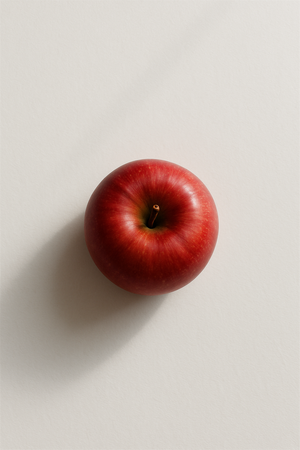

In [ ]:
# Load the image
image_url = "https://raw.githubusercontent.com/natawan/GenAI/main/Apple%20-%20easy.png"
image = Image.open(requests.get(image_url, stream=True).raw)

# Image size
base_width = 300
w_percent = (base_width / float(image.size[0]))
h_size = int((float(image.size[1]) * float(w_percent)))
resized_image = image.resize((base_width, h_size), Image.LANCZOS)

# Display the image
display(resized_image)

In [ ]:
from PIL import Image
import requests
image_url = "https://raw.githubusercontent.com/natawan/GenAI/main/Apple%20-%20easy.png"
image = Image.open(requests.get(image_url, stream=True).raw)
question = 'what object is placed on the table?	'
pipe(image, question, top_k=1)

[{'score': 0.05564265325665474, 'answer': 'leather'}]

While the setup successfully integrated image-text preprocessing and label encoding, the model struggled to generalize — producing low-confidence, incorrect answers (i.e. labeling an apple as “leather”). This underperformance likely stems from the limited training data and the lack of domain-specific fine-tuning. Although the architecture of ViLT is well-suited for joint vision-language learning, our results suggest that effective fine-tuning requires a significantly larger and more diverse dataset to avoid underfitting.

#Reference

* dandelin, n.d. dandelin/vilt-b32-finetuned-vqa. [online] Available at: https://huggingface.co/dandelin/vilt-b32-finetuned-vqa [Accessed 10 May 2025].
* microsoft, n.d. microsoft/git-base-vqa. [online] Available at: https://huggingface.co/microsoft/git-base-vqa [Accessed 10 May 2025].
* Salesforce, n.d. Salesforce/blip2-opt-2.7b. [online] Available at: https://huggingface.co/Salesforce/blip2-opt-2.7b [Accessed 10 May 2025].
* Hugging Face, n.d. BLIP-2 model documentation. [online] Available at: https://huggingface.co/docs/transformers/en/model_doc/blip-2 [Accessed 10 May 2025].
* Hugging Face, n.d. ViLT model documentation. [online] Available at: https://huggingface.co/docs/transformers/model_doc/vilt [Accessed 10 May 2025].
* Hugging Face, n.d. GIT model documentation. [online] Available at: https://huggingface.co/docs/transformers/en/model_doc/git [Accessed 10 May 2025].